In [ ]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib import pyplot
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your dataset in Google Drive
data_path = '/content/drive/MyDrive/GTZAN Images/images_original/'

# # Define transforms for the dataset (resize, convert to tensor)
# transform = transforms.Compose([
#     transforms.Resize((432, 288)),  # Resize images to desired dimensions
#     transforms.ToTensor(),          # Convert images to tensors
# ])

# # Load the dataset using ImageFolder
# dataset = ImageFolder(root=data_path, transform=transform)

# # Initialize empty lists to store image data and labels
# images = []
# labels = []

# # Iterate through the dataset to extract images and labels
# for img, label in dataset:
#     images.append(img.numpy())  # Convert image tensor to numpy array and append to images list
#     labels.append(label)        # Append label to labels list

# # Convert lists to numpy arrays
# images_array = np.array(images)
# labels_array = np.array(labels)

# # Print the shapes of the arrays to verify dimensions
# print("Images Shape:", images_array.shape)  # (num_samples, channels, height, width)
# print("Labels Shape:", labels_array.shape)  # (num_samples,)

Mounted at /content/drive


In [3]:
from PIL import Image
import numpy as np
import os

resized_images = []
labels = []

target_height = 432
target_width = 288

# Iterate through the dataset to load, resize, and store images along with labels
for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):
        label = folder_name  # Assuming folder names are the labels/genres
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_name.endswith('.png') or image_name.endswith('.jpg'):
                img = Image.open(image_path)
                img = img.resize((target_width, target_height))  # Resize images to target dimensions
                resized_images.append(np.array(img))  # Convert resized image to numpy array and append
                labels.append(label)

# Convert lists to numpy arrays
images_array = np.array(resized_images)
labels_array = np.array(labels)

# Print the shapes of the arrays to verify dimensions
print("Images Shape:", images_array.shape)  # (num_samples, height, width, channels)
print("Labels Shape:", labels_array.shape)  # (num_samples,)

Images Shape: (1010, 432, 288, 4)
Labels Shape: (1010,)


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images_array, labels_array, test_size=0.2, random_state=42)

# Print the shapes of the arrays to verify dimensions
print("Train Images Shape:", train_images.shape)  # (num_train_samples, height, width, channels)
print("Train Labels Shape:", train_labels.shape)  # (num_train_samples,)
print("Test Images Shape:", test_images.shape)    # (num_test_samples, height, width, channels)
print("Test Labels Shape:", test_labels.shape)    # (num_test_samples,)

Train Images Shape: (808, 432, 288, 4)
Train Labels Shape: (808,)
Test Images Shape: (202, 432, 288, 4)
Test Labels Shape: (202,)


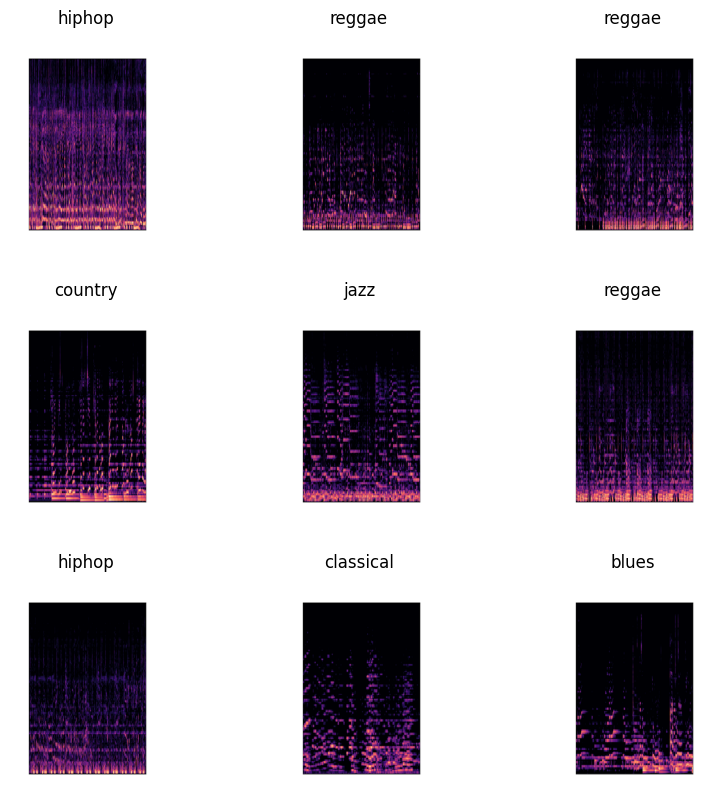

In [5]:
# Visualizing the GTZAN images
sample_img_idx = np.random.randint(0, train_images.shape[0]+1, 9)
plt.figure(figsize=(10,10))
for i, j in enumerate(sample_img_idx):
    image, label = train_images[j], train_labels[j]
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(label)
    plt.axis('off')

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Assuming you have loaded your data into train_images, train_labels, test_images, and test_labels

# Step 1: Label Encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Step 2: One-Hot Encoding
num_classes = len(label_encoder.classes_)  # Determine the number of unique classes
train_labels = to_categorical(train_labels_encoded, num_classes=num_classes)
test_labels = to_categorical(test_labels_encoded, num_classes=num_classes)

# Print shapes to verify
print("Train Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)
print("Train Labels Shape (One-Hot Encoded):", train_labels.shape)
print("Test Labels Shape (One-Hot Encoded):", test_labels.shape)

Train Images Shape: (808, 432, 288, 4)
Test Images Shape: (202, 432, 288, 4)
Train Labels Shape (One-Hot Encoded): (808, 10)
Test Labels Shape (One-Hot Encoded): (202, 10)


In [7]:
# Normalizing and reshaping the data**
#First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5].
#Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# # Reshape the images.
# train_images = np.expand_dims(train_images, axis=3)
# test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)
print(train_labels.shape) # (60000, 10)
print(test_labels.shape)  # (10000, 10)

(808, 432, 288, 4)
(202, 432, 288, 4)
(808, 10)
(202, 10)


In [8]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = 10
batch_size  = 10
# input_shape = (train_images.shape[1:]) # (28, 28, 1)
input_shape = (432, 288, 4)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down.
                      # When padding="same" and strides=1, the output has the same size as the input
model = Sequential()
model.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers

model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
model.add(Dense(num_classes, activation='softmax')) # output layer

# Different syntax, different padding
model_2 = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'),
  MaxPooling2D(pool_size=pool_size),
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),
  MaxPooling2D(pool_size=(pool_size, pool_size)),
  Dropout(0.25),
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

In [9]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 430, 286, 32)      1184      
                                                                 
 max_pooling2d (MaxPooling2  (None, 215, 143, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 141, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 106, 70, 64)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 106, 70, 64)       0         
                                                                 
 flatten (Flatten)           (None, 474880)            0

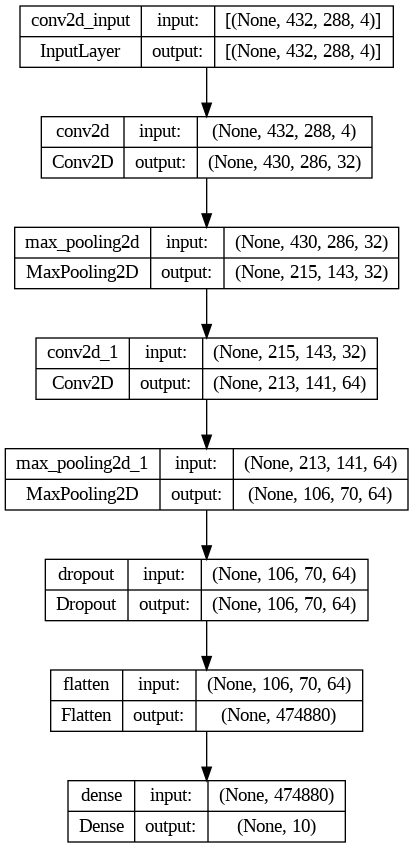

In [10]:
# Plot model
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [11]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [12]:
# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 30

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [13]:
# Fitting the model
history = model.fit(
  train_images,
  train_labels,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(test_images, test_labels), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 8.0676 - accuracy: 0.2413
Epoch 1: val_loss improved from inf to 1.74809, saving model to mnist_best_model.hdf5
81/81 [==============================] - 9s 49ms/step - loss: 8.0676 - accuracy: 0.2413 - val_loss: 1.7481 - val_accuracy: 0.4158
Epoch 2/30
 1/81 [..............................] - ETA: 2s - loss: 1.3700 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/81 [============================>.] - ETA: 0s - loss: 1.1014 - accuracy: 0.6450
Epoch 2: val_loss improved from 1.74809 to 1.66037, saving model to mnist_best_model.hdf5
81/81 [==============================] - 2s 28ms/step - loss: 1.1117 - accuracy: 0.6423 - val_loss: 1.6604 - val_accuracy: 0.5000
Epoch 3/30
81/81 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.7772
Epoch 3: val_loss improved from 1.66037 to 1.39512, saving model to mnist_best_model.hdf5
81/81 [==============================] - 2s 28ms/step - loss: 0.7517 - accuracy: 0.7772 - val_loss: 1.3951 - val_accuracy: 0.5693
Epoch 4/30
80/81 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9663
Epoch 4: val_loss improved from 1.39512 to 1.22156, saving model to mnist_best_model.hdf5
81/81 [==============================] - 2s 29ms/step - loss: 0.2262 - accuracy: 0.9666 - val_loss: 1.2216 - val_accuracy: 0.5941
Epoch 5/30
80/81 [============================>.] - ETA: 0s - loss: 0

In [18]:
# availale keys in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


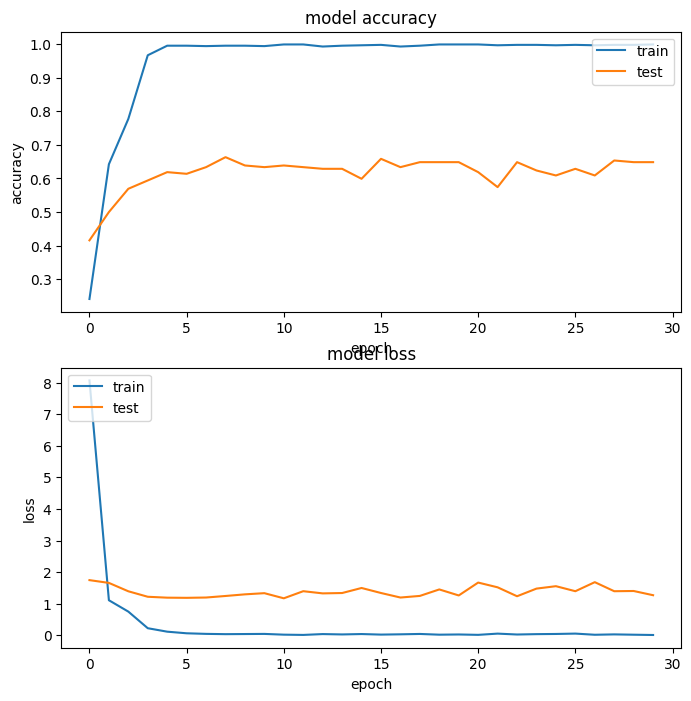

In [19]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1

    return error, confusions

7/7 [==============================] - 1s 23ms/step
Test error: 35.1%


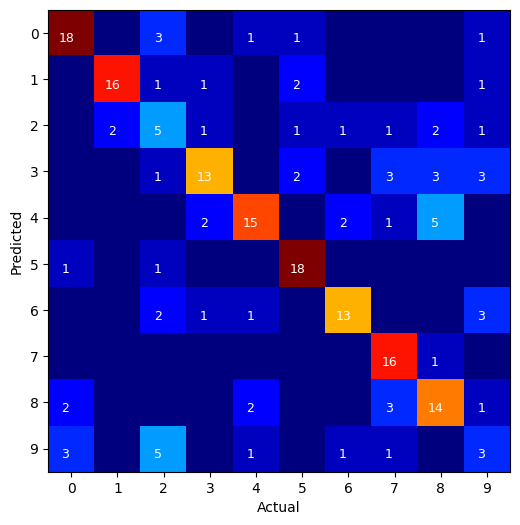

In [17]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(test_images),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(test_labels,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')